# Статистический анализ данных
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

без подписки
* абонентская плата отсутствует;
* стоимость одной минуты поездки — 8 рублей;
* стоимость старта (начала поездки) — 50 рублей;

с подпиской Ultra
* абонентская плата — 199 рублей в месяц;
* стоимость одной минуты поездки — 6 рублей;
* стоимость старта — бесплатно.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt, factorial

In [ ]:
# Настройки
# Отображение всех колонок таблиц
pd.set_option('display.max_columns', None)

# Шаг 1. Загрузка данных

In [ ]:
# функция вывода информации о датасете
def dataset_info(dataset):
    print(dataset.info())
    display(dataset.head())

In [ ]:
# функция проверки на дубликаты и пустые значения
def dataset_isdub_isnull(dataset):
    print('Количество явных дубликатов в датасете:', dataset.duplicated().sum())
    print('Количество пропусков в датасете:')
    print(dataset.isnull().sum())

In [ ]:
# загружаем датафреймы
try:
    df_users = pd.read_csv('/datasets/users_go.csv')
    df_rides = pd.read_csv('/datasets/rides_go.csv')
    df_subs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    df_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    df_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    df_subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

### Датафрейм "Пользователи"

In [ ]:
dataset_info(df_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


### Датафрейм "Поездки"

In [ ]:
dataset_info(df_rides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


### Датафрейм "Подписки"

In [ ]:
dataset_info(df_subs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Промежуточный вывод**

Все датафреймы загрузились без ошибок. В данных отсутствуют пропуски.

Замечено: в датафрейме "Поездки" поле 'date' имеет тип 'object'

# Шаг 2. Предобработка данных

### "Пользователи"

*   user_id	- уникальный идентификатор пользователя
*   name -	имя пользователя
*   age -	возраст
*   city -	город
*   subscription_type -	тип подписки (free, ultra)

In [ ]:
# проверка на дубликаты и пропуски
dataset_isdub_isnull(df_users)

Количество явных дубликатов в датасете: 31
Количество пропусков в датасете:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


In [ ]:
# удалим дубликаты
df_users = df_users.drop_duplicates()
print('Количество явных дубликатов в датасете:', df_users.duplicated().sum())

Количество явных дубликатов в датасете: 0


In [ ]:
# оценим записи в 'city'
print('Список уникальных наименований населенных пунктов:', len(df_users['city'].unique()))
print(df_users['city'].value_counts())

Список уникальных наименований населенных пунктов: 8
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


По-хорошему, населенные пункты следовало бы тоже выделить в отдельную таблицу.
Оставим пока как есть

### "Поездки"

*   user_id	- уникальный идентификатор пользователя
*   distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
*   duration -	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
*   date - дата совершения поездки

In [ ]:
# проверка на дубликаты и пропуски
dataset_isdub_isnull(df_rides)

Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
user_id     0
distance    0
duration    0
date        0
dtype: int64


In [ ]:
# изменим тип в 'date' на datetime
df_rides.date = pd.to_datetime(df_rides.date, format='%Y-%m-%d')

# cоздадим новый столбец с номером месяца на основе столбца date
df_rides['month'] = df_rides.date.dt.month
df_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [ ]:
print('Период дат из датафрейма: c', df_rides.date.min(),'по', df_rides.date.max())


Период дат из датафрейма: c 2021-01-01 00:00:00 по 2021-12-30 00:00:00


### "Подписки"

*   subscription_type - тип подписки
*   minute_price - стоимость одной минуты поездки по данной подписке
*   start_ride_price - стоимость начала поездки
*   subscription_fee - стоимость ежемесячного платежа

In [ ]:
# оценим записи в 'subscription_type'
print('Список подписок:', len(df_users['subscription_type'].unique()))
print(df_users['subscription_type'].value_counts())

Список подписок: 2
free     835
ultra    699
Name: subscription_type, dtype: int64


В таблице всего две строки. дубликатов и пропусков в ней нет

**Промежуточный вывод**

Провели предобработку данных.
* обнаружили и удалили дубликаты в датафрейме "Пользователи"
* изменили тип в 'date' на datetime
* cоздали новый столбец с номером месяца на основе столбца date

# Шаг 3. Исследовательский анализ данных

### 3.1 Частота встречаемости городов

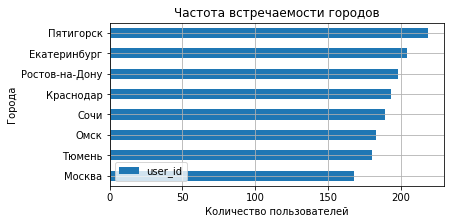

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [ ]:
df_users_city = df_users.pivot_table(index = 'city', values = 'user_id', aggfunc = 'count')
df_users_city = df_users_city.sort_values(by='user_id', ascending = True)
df_users_city.plot( kind='barh', figsize = (6,3), grid = True )
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Города')
plt.legend(loc='lower left')
plt.show()
display(df_users_city.sort_values(by='user_id', ascending = False))

**Вывод**

* датафреймы содержат данные о пользователях из 8-ми городов
* больше всего пользователей из Пятигорска, меньше всего из Москвы

### 3.2 Соотношение пользователей с подпиской и без

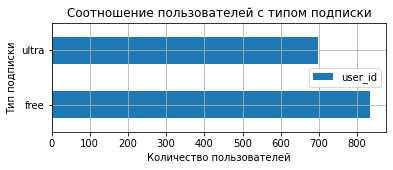

,subscription_type,user_id
0,free,835
1,ultra,699


In [ ]:
df_users_subs = df_users.pivot_table(index = 'subscription_type', values = 'user_id', aggfunc = 'count').reset_index()
df_users_subs.plot(x = 'subscription_type', kind='barh', figsize = (6,2), grid = True )
plt.title('Соотношение пользователей с типом подписки')
plt.xlabel('Количество пользователей')
plt.ylabel('Тип подписки')
plt.show()
display(df_users_subs)

Пользователей без подписки больше чем больше чем пользователей с подпиской Ultra

### 3.3 Возраст пользователей

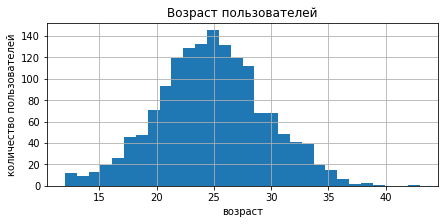

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [ ]:
df_users['age'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30)
plt.title('Возраст пользователей')
plt.xlabel('возраст')
plt.ylabel('количество пользователей')
plt.show()
df_users['age'].describe()

Выборка имеет нормальное распределение. Медиана и средний возраст почти совпадают: 25 и 24.9 лет соответственно.

### 3.4 Расстояние, которое пользователь преодолел за одну поездку

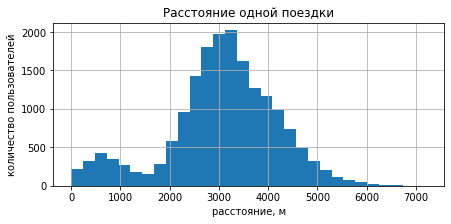

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [ ]:
df_rides['distance'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30)
plt.title('Расстояние одной поездки')
plt.xlabel('расстояние, м')
plt.ylabel('количество пользователей')
plt.show()
df_rides['distance'].describe()

Среднее расстояние большинства поездок чуль больше 3-х километров. Есть небольшой всплеск около поездок на 600м, можно предположить что эти поезки совершали пользователи, что бы добраться до станций метро или других остановок общественно транспорта.

### 3.5 Продолжительность поездок

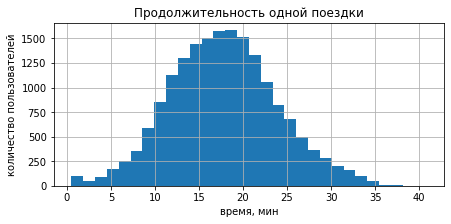

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [ ]:
df_rides['duration'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30)
plt.title('Продолжительность одной поездки')
plt.xlabel('время, мин')
plt.ylabel('количество пользователей')
plt.show()
df_rides['duration'].describe()

Выборка также похожа на распределение Гаусса. Среднее время поездки 17.7 мин

# Шаг 4. Объединение данных

#### 4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [ ]:
df_mrg = df_rides.copy()
df_mrg = df_mrg.merge(df_users, how = 'left', on = 'user_id' )
df_mrg = df_mrg.merge(df_subs, how = 'left', on='subscription_type')
display(df_mrg)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


#### 4.2 Создадим датафреймы из df_mrg, созданного на этапе 4.1:
*   c данными о пользователях без подписки
*   с данными о пользователях с подпиской.

In [ ]:
df_mrg_free = df_mrg[df_mrg['subscription_type'] == 'free']
display(df_mrg_free.head())
print('Количество строк в датасете df_mrg_free:', df_mrg_free.shape[0])

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Количество строк в датасете df_mrg_free: 11568


In [ ]:
df_mrg_ultra = df_mrg[df_mrg['subscription_type'] == 'ultra']
display(df_mrg_ultra.head())
print('Количество строк в датасете df_mrg_ultra:', df_mrg_ultra.shape[0])

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Количество строк в датасете df_mrg_ultra: 6500


#### 4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

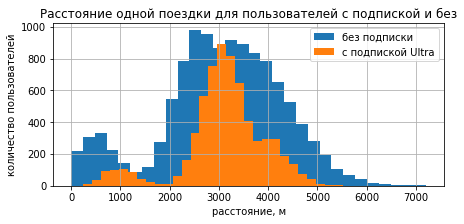

In [ ]:
ax = df_mrg_free['distance'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30, label='без подписки')
ax = df_mrg_ultra['distance'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30, label='с подпиской Ultra')
plt.title('Расстояние одной поездки для пользователей с подпиской и без')
plt.xlabel('расстояние, м')
plt.ylabel('количество пользователей')
plt.legend(loc='upper right')
plt.show()

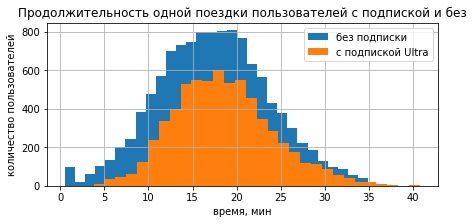

In [ ]:
df_mrg_free['duration'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30, label='без подписки')
df_mrg_ultra['duration'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30, label='с подпиской Ultra')
plt.title('Продолжительность одной поездки пользователей с подпиской и без')
plt.xlabel('время, мин')
plt.ylabel('количество пользователей')
plt.legend(loc='upper right')
plt.show()

**Вывод**

* Объединили 3 датафрейма в один общий. Создали еще два датафрейма с данными о пользователях с подпиской и без подписки
* На ставнительных графиках видим разницу в расстоянии и времени поездок в двух категориях пользователей


# Шаг 5. Подсчёт выручки

#### 5.1
Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [ ]:
# округлим время поезки до следующего целого числа
df_mrg['duration'] = np.ceil(df_mrg['duration'])
df_mrg['duration'] = df_mrg['duration'].astype('int')

df_mrg_agg = df_mrg.pivot_table(index= ['user_id', 'month'], values = ['distance', 'duration'], aggfunc = ['count', 'sum'])
df_mrg_agg.columns = ['_'.join(col) for col in df_mrg_agg.columns.values]
df_mrg_agg = df_mrg_agg.drop(columns=['count_duration'])
df_mrg_agg = df_mrg_agg.reset_index()
display(df_mrg_agg)

,user_id,month,count_distance,sum_distance,sum_duration
0,1,1,2,7027.511294,42
1,1,4,1,754.159807,7
2,1,8,2,6723.470560,46
3,1,10,2,5809.911100,32
4,1,11,3,7003.499363,56
...,...,...,...,...,...
11326,1534,6,2,3409.468534,26
11327,1534,8,2,7622.453034,48
11328,1534,9,1,4928.173852,23
11329,1534,11,4,13350.015305,78


*   count_distance - количество поездок за месяц
*   sum_distance - общая дистанция за месяц
*   sum_duration - общая продолжительность поездок за месяц



#### 5.2
Добавляем столбец с помесячной выручкой, которую принёс каждый пользователь

In [ ]:
df_mrg_agg = df_mrg_agg.merge(df_users, how='left', on='user_id')
df_mrg_agg = df_mrg_agg.merge(df_subs, how = 'left', on='subscription_type')
display(df_mrg_agg)

,user_id,month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.159807,7,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.470560,46,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.911100,32,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.499363,56,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26,Альберт,25,Краснодар,free,8,50,0
11327,1534,8,2,7622.453034,48,Альберт,25,Краснодар,free,8,50,0
11328,1534,9,1,4928.173852,23,Альберт,25,Краснодар,free,8,50,0
11329,1534,11,4,13350.015305,78,Альберт,25,Краснодар,free,8,50,0


In [ ]:
# Добавляем столбец с помесячной выручкой, которую принёс каждый пользователь
def gain(row):
  gain_sum = 0
  gain_sum = (row['start_ride_price'] * row['count_distance'] +
              row['minute_price'] * row['sum_duration'] +
              row['subscription_fee']
              )
  return gain_sum

df_mrg_agg['gain'] = df_mrg_agg.apply(gain, axis=1)
display(df_mrg_agg[['user_id', 'name', 'month', 'gain']])

,user_id,name,month,gain
0,1,Кира,1,451
1,1,Кира,4,241
2,1,Кира,8,475
3,1,Кира,10,391
4,1,Кира,11,535
...,...,...,...,...
11326,1534,Альберт,6,308
11327,1534,Альберт,8,484
11328,1534,Альберт,9,234
11329,1534,Альберт,11,824


# Шаг 6. Проверка гипотез

#### 6.1
 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Сравним две выборки, df_mrg_free и df_mrg_ultra и проверим гипотезы:

*   Нулевая теория: среднее время поездок пользователей с подпиской и пользователей без подписки равны
*   Альтернативная гипотеза: пользователи с подпиской тратят больше времени

In [ ]:
alpha = 0.05 # уровень статистической значимости

# так как у нас левосторонняя альтернативная гипотеза используем параметр 'less'
results = st.ttest_ind(df_mrg_ultra['duration'], df_mrg_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Гипотеза верна: среднее время поездок пользователей с подпиской больше время поездок пользователей без подписки

In [ ]:
# проверка
print('Среднее время поездки пользователей c подпиской:', round(df_mrg_ultra['duration'].mean(),2))
print('Среднее время поездки пользователей без подписки:', round(df_mrg_free['duration'].mean(),2))

Среднее время поездки пользователей c подпиской: 18.54
Среднее время поездки пользователей без подписки: 17.39


#### 6.2
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.


Проверим гипотезы:



*   Нулевая гипотеза: среднее расстояние поездки пользователи с подпиской равна 3130 метрам
*   Альтернативная гипотеза: среднее расстояние поездки пользователи с подпиской меньше 3130 метров


In [ ]:
interested_value = 3130 # столько времени должны проводить пользователи на сайте

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(df_mrg_ultra['distance'], interested_value, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу


Средняя дистанция поездки пользователи с подпиской действительно меньше 3130 метров

In [ ]:
print('Среднее дистанция поездки пользователей c подпиской:', round(df_mrg_ultra['distance'].mean(),0))

Среднее дистанция поездки пользователей c подпиской: 3115.0


#### 6.3
Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.



*   Нулевая гипотеза: помесячная выручка от пользователей с подпиской и без равны.
*   Альтернативная гипотеза: помесячная выручка от пользователей с подпиской выше чем выручка от пользователей без подписки

In [ ]:
# создадим две выборки с посчитанной помесячной выручкой
df_mrg_agg_ultra = df_mrg_agg[df_mrg_agg['subscription_type'] == 'ultra']
df_mrg_agg_free = df_mrg_agg[df_mrg_agg['subscription_type'] == 'free']

alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(df_mrg_agg_ultra['gain'], df_mrg_agg_free['gain'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что помесячная выручка от пользователи с подпиской больше.

In [ ]:
# проверка
print('Средняя помесячная выручка от пользователи с подпиской:', round(df_mrg_agg_ultra['gain'].mean(),2))
print('Средняя помесячная выручка от пользователи без подписки:', round(df_mrg_agg_free['gain'].mean(),2))

Средняя помесячная выручка от пользователи с подпиской: 362.79
Средняя помесячная выручка от пользователи без подписки: 328.64


#### 6.4
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В данном случае правильнее применить тест проверки гипотез о равенстве средних для зависимых (парных) выборок. В  метод scipy.stats.ttest_rel() передать два параметра: наборы данных до обновления и после

# Шаг 7. Распределения

#### 7.1
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Для начала воспользуемся графиком биноминального распределения

<BarContainer object of 1001 artists>

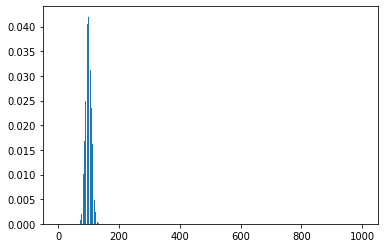

In [ ]:
# определим примерный диапазон значений биномиального распределения графиком
n = 1000
p = 0.1
distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k)
    distr.append(prob)

plt.bar(range(0, n + 1), distr)

В диапазоне (n-500, n+500) определим минимальное количество промокодов чтобы вероятность не выполнить план была не больше 5%

In [ ]:
for n in range (500,1500):
    if binom.cdf(99, n, p) < 0.05:
        print("Минимальное число промокодов:", n)
        break

Минимальное число промокодов: 1161


Для акции раздачи промокодов с целью получения не менее 100 продлений подписок, с вероясностью невыполнения не больше 5% нужно сделать рассылку менее 1161 промокодов

#### 7.2
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать
1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Аппроксимируем биномиальное распределение нормальным и посчитаем

In [ ]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma)

x = 399500

# считаем вероятность получить значение, равное x или меньше
result = distr.cdf(x)

print('Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей:',
      round(result, 2))

Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей: 0.15


**Вывод**

В условиях акции рассылки 1 млн. push-уведомлений вероятность что откроют их не более 399,5 тыс. пользователей - 15%

**Общий вывод**

При анализе данных нам удалось выяснить:

* по предоставленным данным из 8-ми городов, больше всего пользователей из Пятигорска, меньше всего из Москвы.
* средний возраст пользователя сервиса - 24.9 лет
* Среднее расстояние большинства поездок чуль больше 3-х километров. Есть небольшой всплеск около поездок на 600м, можно предположить что эти поезки совершали пользователи, что бы добраться до станций метро или других остановок общественного транспорта
* пользователей сервиса аренды самокатов без подписки больше чем пользователей с подпиской.

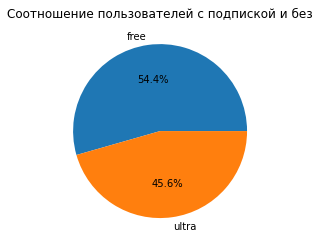

In [ ]:
fig, ax = plt.subplots()
ax.pie(df_users_subs['user_id'], labels=df_users_subs['subscription_type'], autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без')
plt.show()

* средняя помечная выручка от пользователей с подпиской больше чем от пользователей без подписки

В ходе исследования были подтверждены следующие гипотезы:

* с вероятностью 5% время поездок пользователей с подпиской больше время поездок пользователей без подписки
* средняя дистанция поездки пользователи с подпиской меньше 3130 метров (оптимальное расстояние с точки зрения износа самоката)
* помесячная выручка от пользователей с подпиской выше чем выручка от пользователей без подписки


Так же, для отдела маркетинга сделали расчеты:
* для акции раздачи промокодов с целью получения не менее 100 продлений подписок: с нужно сделать рассылку не менее 1161 промокодов
* для акции рассылки 1 млн. push-уведомлений вероятность что откроют их не более 399,5 тыс. пользователей - 15%